# Pruebas de inicialización del reservoir.

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, filtfilt
import random

In [2]:
# carga de los datos.
eeg_synthetic = np.load("./data/data/synthetic_data_auto.npy")
sujeto_synt = eeg_synthetic[0,:,:]

In [3]:
# Parámetros
num_input_channels = 10     # Dimensionalidad de entrada (10 canales)
num_reservoir_neurons = 10   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = sujeto_synt.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Normalización espectral
eigvals = np.linalg.eigvals(res2res)
spectral_radius = np.max(np.abs(eigvals))
desired_radius = 0.9

# Escalar la matriz recurrente
res2res = (res2res / spectral_radius) * desired_radius

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

#influencia del input y de la recurrencia.
alpha = 0.05
beta = 0.95

Text(0.5, 1.0, 'Diferencia entre estados con distintas condiciones iniciales')

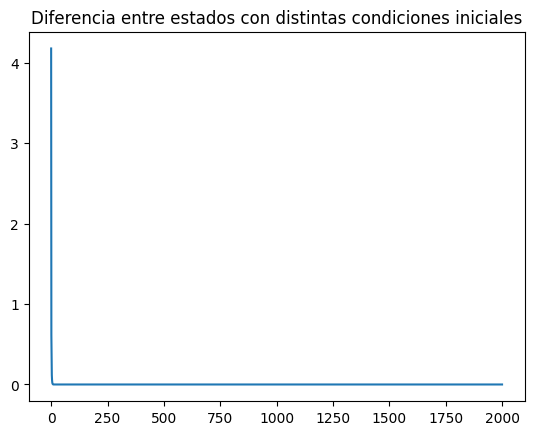

In [4]:
# Dos inicializaciones distintas
init1 = np.zeros((num_reservoir_neurons,))
init2 = np.random.randn(num_reservoir_neurons,)

# Evolucionar con mismo input pero diferentes inicios
state1 = np.zeros((num_reservoir_neurons, num_training_samples))
state2 = np.zeros((num_reservoir_neurons, num_training_samples))
state1[:,0] = init1
state2[:,0] = init2

for i in range(1, num_training_samples):
    u = sujeto_synt[i,:]
    state1[:, i] = np.tanh(alpha * input2res @ u + beta * res2res @ state1[:, i-1] + input_bias.flatten())
    state2[:, i] = np.tanh(alpha * input2res @ u + beta * res2res @ state2[:, i-1] + input_bias.flatten())

# Diferencia entre estados con distinto inicio
diff = np.linalg.norm(state1 - state2, axis=0)
plt.plot(diff)
plt.title("Diferencia entre estados con distintas condiciones iniciales")

# Pruebas de inicialización del clustering.

In [5]:
def bandpass_filter(signal, fs, lowcut, highcut, order=4):
    nyq = fs / 2
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal, axis=1)  # aplica por columnas

In [6]:
# Implementación reservoir clásico con un sujeto joven.

# Parámetros
num_input_channels = 10     # Dimensionalidad de entrada (10 canales)
num_reservoir_neurons = 10   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = sujeto_synt.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Normalización espectral
eigvals = np.linalg.eigvals(res2res)
spectral_radius = np.max(np.abs(eigvals))
desired_radius = 0.9

# Escalar la matriz recurrente
res2res = (res2res / spectral_radius) * desired_radius

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        (0.05 * input2res @ sujeto_synt[i,:]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS_clasico_joven_synt = reservoir_states - np.mean(reservoir_states, axis = 1, keepdims=True)

# Aplicamos un filtro pasa-banda sobre la salida con una frecuencia entre 4 y 12 Hz.

# frecuencia de muestreo: 512 Hz.
fs = 512
RS_filtered_synt = bandpass_filter(RS_clasico_joven_synt, fs, 4, 12)

# Hilbert sobre la señal filtrada
analytic_signal = hilbert(RS_filtered_synt, axis=1)
amplitude_envelope_clasico_joven_synt = np.abs(analytic_signal)

print(analytic_signal.shape)
print(RS_clasico_joven_synt.shape)
print(amplitude_envelope_clasico_joven_synt.shape)

(10, 2001)
(10, 2001)
(10, 2001)


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering

def clustering_gmm(input_sequence, n_components=4, random_state = None):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(input_sequence.T)

    gmm = GaussianMixture(
        n_components=n_components,
        n_init=10,
        max_iter=500,
        tol=1e-3,
        random_state=random_state
    )
    cluster_labels = gmm.fit_predict(X_scaled)
    return cluster_labels, X_scaled

def clustering_spectral(input_sequence, n_components=4, random_state = None):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(input_sequence.T)

    spectral = SpectralClustering(
        n_clusters=n_components,
        affinity='nearest_neighbors',
        n_neighbors=10,
        assign_labels='kmeans',
        random_state=random_state
    )
    cluster_labels = spectral.fit_predict(X_scaled)
    return cluster_labels, X_scaled

In [11]:
from sklearn.metrics import adjusted_rand_score

# Simula varias ejecuciones con seeds diferentes
aris_gmm = []
aris_spectral = []

input_seq = amplitude_envelope_clasico_joven_synt  # o la variable que uses

# Usamos la ejecución con random_state=0 como referencia
ref_gmm,_ = clustering_gmm(input_seq, random_state=0)
ref_spec,_ = clustering_spectral(input_seq, random_state=0)

# Comparamos con 9 ejecuciones más (con otras seeds)
for seed in range(1, 10):
    labels_gmm,_ = clustering_gmm(input_seq, random_state=seed)
    labels_spec,_ = clustering_spectral(input_seq, random_state=seed)
    
    ari_gmm = adjusted_rand_score(ref_gmm, labels_gmm)
    ari_spec = adjusted_rand_score(ref_spec, labels_spec)
    
    aris_gmm.append(ari_gmm)
    aris_spectral.append(ari_spec)

print("Estabilidad GMM (ARI promedio):", np.mean(aris_gmm))
print("Estabilidad Spectral (ARI promedio):", np.mean(aris_spectral))

Estabilidad GMM (ARI promedio): 0.7247078774155906
Estabilidad Spectral (ARI promedio): 1.0


## Visualización del clustering con GMM.

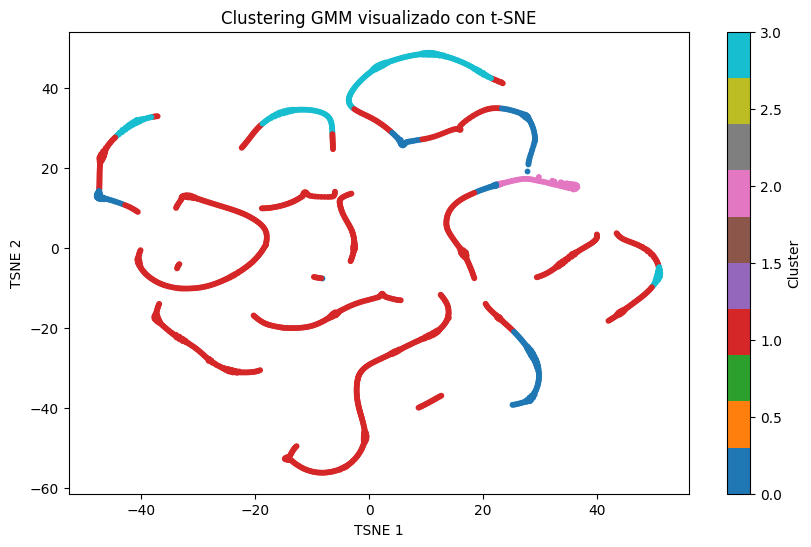

In [12]:
# Función clustering GMM.
labels, data_scaled = clustering_gmm(input_seq, random_state = 42)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
data_tsne = tsne.fit_transform(data_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels, cmap='tab10', s=10)
plt.title('Clustering GMM visualizado con t-SNE')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.colorbar(label='Cluster')
plt.show()

## Visualización del clustering con Spectral Clustering.

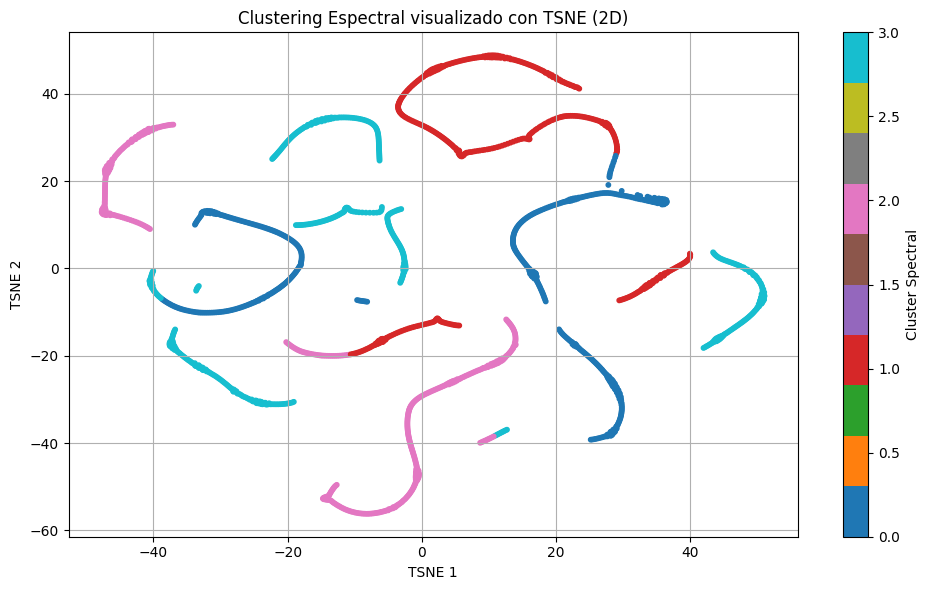

In [13]:
labels_spectral,_ = clustering_spectral(input_seq, random_state = 42)

# 2. Visualizar los clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels_spectral, cmap='tab10', s=10)
plt.title('Clustering Espectral visualizado con TSNE (2D)')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.colorbar(scatter, label='Cluster Spectral')
plt.grid(True)
plt.tight_layout()
plt.show()